# KMeans Clustering using Spark

## Step 1 : Import libraries and Load the Iris dataset

In [2]:
#######################################################################################################################

#Reference : https://www.data4v.com/tutorial-k-means-clustering-on-spark/

#######################################################################################################################

import findspark
import pandas as pd
from sklearn.datasets import load_iris
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark import SparkConf

#Initialize spark location
findspark.init('/home/ubuntu/hadoop/spark-3.3.0')

#Create spark context
# conf = SparkConf().setAppName("IrisExample").setMaster("local")
# sc = SparkContext.getOrCreate(conf)
# spark = SQLContext(sc)
conf = SparkConf().setAppName("IrisKmeans").setMaster("local")
sc = SparkContext.getOrCreate(conf)
spark = SQLContext(sc)

#Load iris dataset
df_iris = load_iris(as_frame=True)
pd_df_iris = pd.DataFrame(df_iris.data, columns = df_iris.feature_names)
pd_df_iris['target'] = pd.Series(df_iris.target)

spark_df_iris = spark.createDataFrame(pd_df_iris)
spark_df_iris = spark_df_iris.drop("target")

print(f'Size of Iris dataset : {pd_df_iris.size}')
pd_df_iris.head()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/ubuntu/hadoop/spark-3.3.0/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/ubuntu/hadoop/hadoop-3.3.2/share/hadoop/common/lib/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


22/09/09 15:54:33 WARN Utils: Your hostname, MSI resolves to a loopback address: 127.0.1.1; using 172.28.105.141 instead (on interface eth0)
22/09/09 15:54:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/09 15:54:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/home/ubuntu/.local/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Size of Iris dataset : 750


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Transform features into a single feature set

In [3]:
assemble=VectorAssembler(inputCols=[
'sepal length (cm)',
'sepal width (cm)',
'petal length (cm)',
'petal width (cm)'],outputCol = 'iris_features')

assembled_data=assemble.transform(spark_df_iris)

## Find optimal number of clusters using the silhouette method

In [4]:
# Array to hold silhouette scored for all values of K 
silhouette_scores=[]

evaluator = ClusteringEvaluator(featuresCol='iris_features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='iris_features', k=K)
    
    # Fit the Iris dataset onto KMeans model
    KMeans_fit=KMeans_.fit(assembled_data)

    KMeans_transform=KMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

## Plot the silouette score vs number of clusters (Elbow Method)

Text(0, 0.5, 'Silhouette Score')

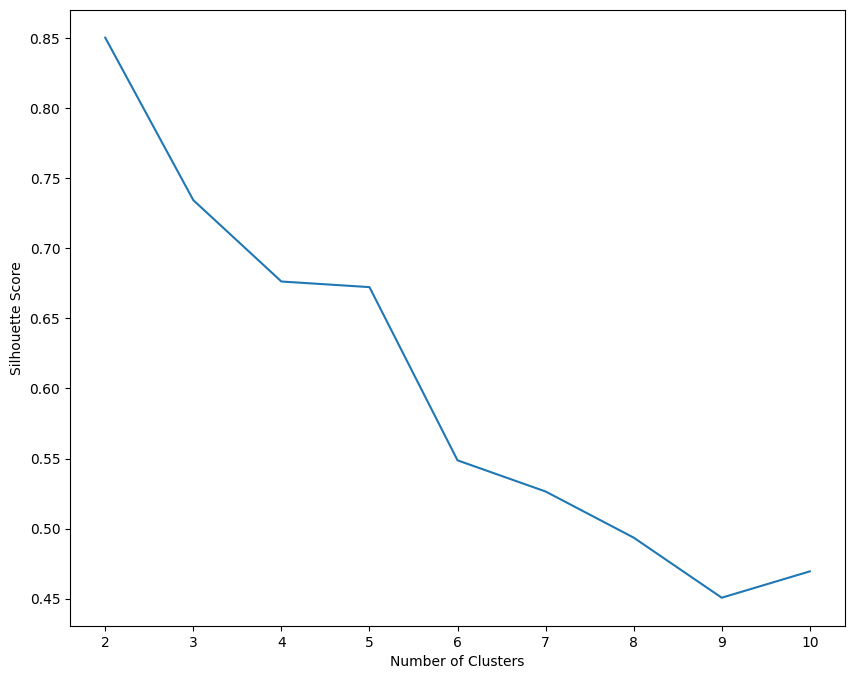

In [5]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

Using elbow method, we can see that the first elbow occurs at K = 3, showing that 3 clusters is the optimal value.

## Create K Means model with optimal K = 3 clusters

In [6]:
KMeans_=KMeans(featuresCol='iris_features', k=3) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

## Use PCA for dimensionality reduction to visualize in 2D

In [7]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=2, inputCol="iris_features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

22/09/09 15:58:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/09/09 15:58:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/09/09 15:58:50 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/09/09 15:58:50 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [4]:
import numpy as np

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

# Cluster assignment to plot
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

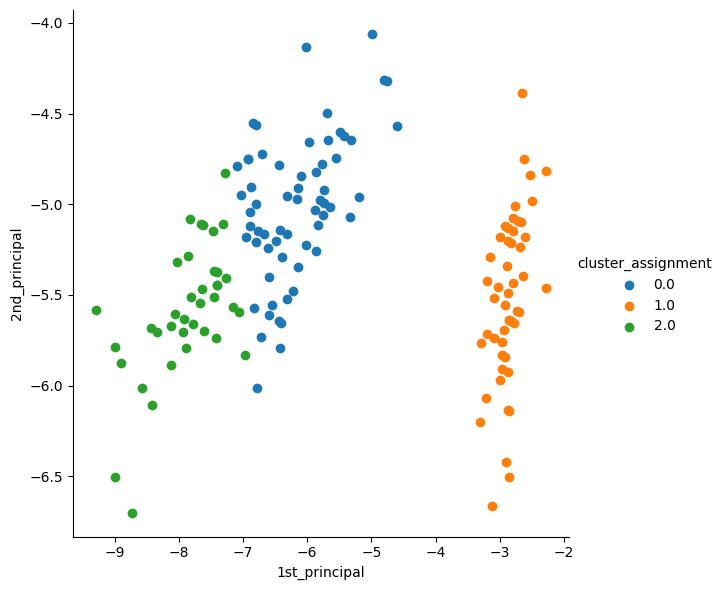

In [7]:

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [51]:
sc.stop()
sc.getConf().getAll()

[('spark.master', 'local'),
 ('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.id', 'local-1662752870639'),
 ('spark.app.submitTime', '1662740430810'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'localhost'),
 ('spark.app.startTime', '1662752870603'),
 ('sp